# Indeed.com -- Salary Prediction

In this notebook, we'll scrape the Indeed.com website for salary listings using the keyword "Data Scientist" in the top 25 most populous U.S. cities.  Then, we'll try to construct a logistic regression model to predict whether a given listing will have a salary that falls above or below the median of all training salaries.

First, we import and set up our environment:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import datetime
import requests
from bs4 import BeautifulSoup
import re

from scipy.stats import gaussian_kde
from nltk.stem.porter import *

from matplotlib import pyplot as plt
from matplotlib import cm as cm2
from matplotlib import patheffects as path_effects

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, \
                                    roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, \
                                    GridSearchCV
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Here we go; let's scrape Indeed.com 'Data Scientist' job listings for the [top 25 most-populous cities](https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population) in the United States, up to a maximum of 1000 results per city.  Here are some functions we will use to process the scrapes:

In [2]:
def get_jobtitle(result):
    '''This function constructs a list containing each job title.'''
    jobtitle_list = []
    try:
        for i in result.findAll('a', class_ = 'jobtitle turnstileLink'): 
            jobtitle_list.append(str(i.text.encode('utf8')))
    except:
        jobtitle_list.append(None)
    return jobtitle_list

def get_location(result):
    '''This function constructs a list containing each job location.'''
    location_list = []
    try:
        for i in result.findAll('span', class_ = 'location'):
            location_list.append(str(i.text.encode('utf8')))
    except:
        location_list.append(None)
    return location_list

def get_company(result):   
    '''This function constructs a list containing each job company.'''
    company_list = []
    try:
        for i in result.findAll('span', class_ = 'company'):
            company = str(i.text.encode('utf8'))
            company = company.replace('\n', '')
            company = company.replace('    ', '')
            company_list.append(company)
    except:
        company_list.append(None)
    return company_list
    
def get_salary(result):
    '''This function constructs a list containing each job salary.'''
    salary_list = []
    try:
        for i in result.findAll('td', class_ = 'snip'):
            try:
                salary_list.append(i.find('nobr').text)
            except:
                salary_list.append(None)
    except:
        salary_list.append(None)
    return salary_list

def putitalltogether(result):
    '''This function creates a dataframe whose columns are the lists produced \
    by the functions it contains.'''
    jobs = get_jobtitle(result)
    locations = get_location(result)
    companies = get_company(result)
    salaries = get_salary(result)
    df = pd.DataFrame(zip(jobs, locations, companies, salaries),\
                        columns = ['title', 'location', 'company', 'salary']) 
    return df

In [ ]:
# url_template = ['http://www.indeed.com/jobs?q=data+scientist&l=', '&start=']

# max_results_per_city = 1000

# ## Create empty dataframe with the columns we want; \
# ## concatenate to it the new one generated for each city

# df = pd.DataFrame(columns=['title', 'location', 'company', 'salary', 'city', 'state'])

# count = 0

# starter = datetime.datetime.now()
# print starter

# cities = ['New+York,+NY', 'Los+Angeles,+CA', 'Chicago,+IL', 'Houston,+TX', 'Philadelphia,+PA', \
#           'Phoenix,+AZ', 'San+Antonio,+TX', 'San+Diego,+CA', 'Dallas,+TX', 'San+Jose,+CA', \
#           'Austin,+TX', 'Jacksonville,+FL', 'San+Francisco,+CA', 'Indianapolis,+IN', \
#           'Columbus,+OH', 'Fort+Worth,+TX', 'Charlotte,+NC', 'Seattle,+WA', 'Denver,+CO', \
#           'El+Paso,+TX', 'Detroit,+MI', 'Washington,+DC', 'Boston,+MA', 'Memphis,+TN', \
#           'Nashville,+TN']

# for city in cities:
#     print city.split(',')[0].replace('+', ' '),
#     for start in range(0, max_results_per_city, 10):
#         # Grab the results from the request (as above)
#         URL = url_template[0] + city + url_template[1] + str(start)
#         indeed = requests.get(URL)
#         soup = BeautifulSoup(indeed.content, "lxml")
#         # Append to the full set of results and 
#         big = putitalltogether(soup)
#         nice_city = city.split(',')
#         state = nice_city[1]
#         state = state.replace('+', '')
#         nice_city = nice_city[0]
#         nice_city = nice_city.replace('+', ' ')
#         big['city'] = nice_city
#         big['state'] = state
#         df = pd.concat([big, df], axis = 0) 
#         if count%50 == 0:
#             print '.',
#         count += 1
        
# finish = datetime.datetime.now()
# print finish - starter
        
#df.to_csv('assets/indeed2017_rough.csvXXX', index = False)

The following cell loads the data frame constructed during the scrape:

In [3]:
df = pd.read_csv('assets/indeed2017_rough.csv')
orig = len(df)
df.head()

,title,location,company,salary,city,state
0,Certifying Scientist,"Nashville, TN 37228",Aegis Sciences Corporation,NaN,Nashville,TN
1,Machine Learning Specialist,"Nashville, TN",Advent Health Partners,NaN,Nashville,TN
2,NLP Data Scientist,"Nashville, TN 37211",LEAD Public Schools,NaN,Nashville,TN
3,Data Scientist,"Nashville, TN 37211",LEAD Public Schools,NaN,Nashville,TN
4,Data Scientist (Relocation Offered),"Nashville, TN 37232",Vanderbilt University Medical Center,NaN,Nashville,TN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15956 entries, 0 to 15955
Data columns (total 6 columns):
title       15956 non-null object
location    15956 non-null object
company     15956 non-null object
salary      405 non-null object
city        15956 non-null object
state       15956 non-null object
dtypes: object(6)
memory usage: 748.0+ KB


Whoa, looks like we only have 405 non-null salary entries.  Let's get rid of all observations containing empty salary cells:

In [6]:
df = df.dropna()
df = df.drop_duplicates()
df.reset_index(drop = True, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
title       120 non-null object
location    120 non-null object
company     120 non-null object
salary      120 non-null object
city        120 non-null object
state       120 non-null object
dtypes: object(6)
memory usage: 5.7+ KB


In [7]:
len(df)/float(orig)

0.007520681875156681

So we're already down to about 0.75% of the original scrape without any advanced cleaning!

#### Filter out the salaries that are not yearly:

In [8]:
df = df[df['salary'].str.contains('month') == False]
df = df[df['salary'].str.contains('week') == False]
df = df[df['salary'].str.contains('hour') == False]
df = df[df['salary'].str.contains('day') == False]

In [9]:
print 'Of %s' %len(df[df['salary'] != 'NaN']) +' salaries remaining, %s' \
%len(df[df['salary'].str.contains('year')]) +' are explicitly labeled as \'yearly.\''

Of 96 salaries remaining, 96 are explicitly labeled as 'yearly.'


#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [10]:
df['salary'] = [x.replace('$', '') for x in df['salary']]
df['salary'] = [x.replace(',', '') for x in df['salary']]
df['salary'] = [x.replace(' a year', '') for x in df['salary']]
df['salary'] = [x.split(' - ') for x in df['salary']]
df['salary'] = [float(x[0]) if len(x) == 1 else (float(x[0]) + float(x[1]))/2.0 for x in df['salary']]
df['salary'][0:10]

0    100000.0
1    155000.0
2    170000.0
3    170000.0
4    120000.0
5     45000.0
6    115000.0
7    135000.0
8     80000.0
9     80000.0
Name: salary, dtype: float64

Let's see what a histogram of the salary column looks like:

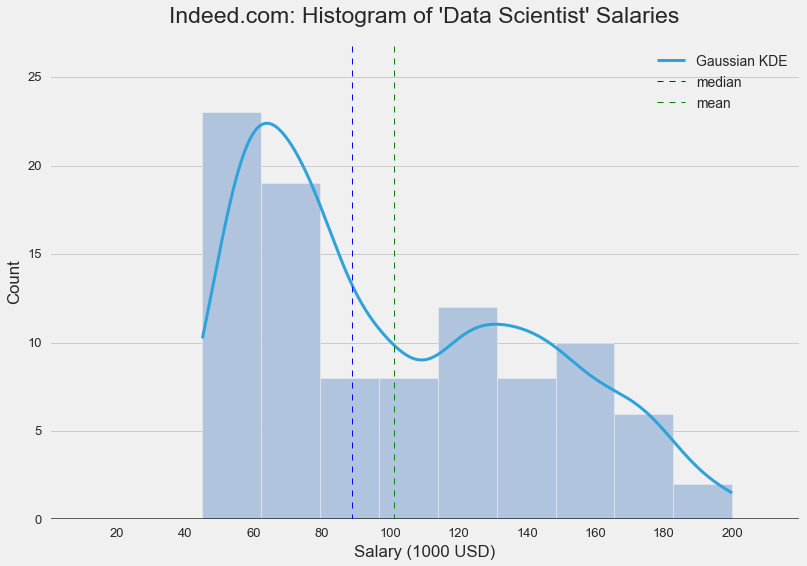

In [12]:
plt.figure(figsize = (12,8))
plt.style.use('fivethirtyeight')

df['salary'].hist(bins = 9, color = 'lightsteelblue')

density = gaussian_kde(df['salary'])
xs = np.linspace(df['salary'].min(), df['salary'].max(), 1000)
density.covariance_factor = lambda : 0.25
density._compute_covariance()
plt.plot(xs,density(xs)*10000000/5.5, linewidth = 3.0, label = 'Gaussian KDE')

plt.title('Indeed.com: Histogram of \'Data Scientist\' Salaries', fontsize = 23, y = 1.03)
plt.ylim([0, 27])
plt.yticks(range(0, 30, 5), fontsize = 13)
plt.ylabel('Count')
plt.xlim([0, 200000])
plt.xticks(range(20000, 240000, 20000), range(20, 220, 20), fontsize = 13)
plt.xlabel('Salary (1000 USD)')

plt.axhline(0, color = 'black', alpha = 0.6)
plt.axvline(df['salary'].median(), color='b', linestyle='dashed', linewidth=1.0, \
            label = 'median')
plt.axvline(df['salary'].mean(), color='g', linestyle='dashed', linewidth=1.0, \
            label = 'mean')

plt.grid(which='major', axis = 'x')
plt.legend(loc = 'best', fontsize = 14)
plt.show()

And now, let's see a bar chart of all the states included in the scrape:

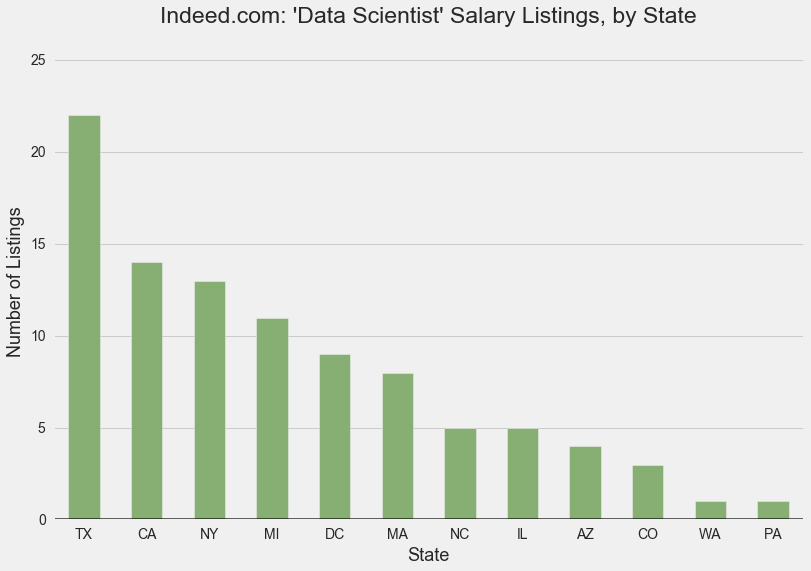

In [13]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df['state'].value_counts().plot.bar(color = 'sage')

plt.axhline(0, color='black', alpha = 0.6)

plt.title('Indeed.com: \'Data Scientist\' Salary Listings, by State', fontsize = 23, y = 1.03)

# y label
plt.ylabel('Number of Listings', fontsize = 18)
plt.yticks(range(0, 30, 5), fontsize = 14)
plt.ylim([0, 26])

# x label
plt.xlabel('State', fontsize = 18)
plt.xticks(rotation = 0, fontsize = 14)

plt.grid(which = 'major', axis = 'x')

plt.show()

And a bar chart of all the cities included in the scrape:

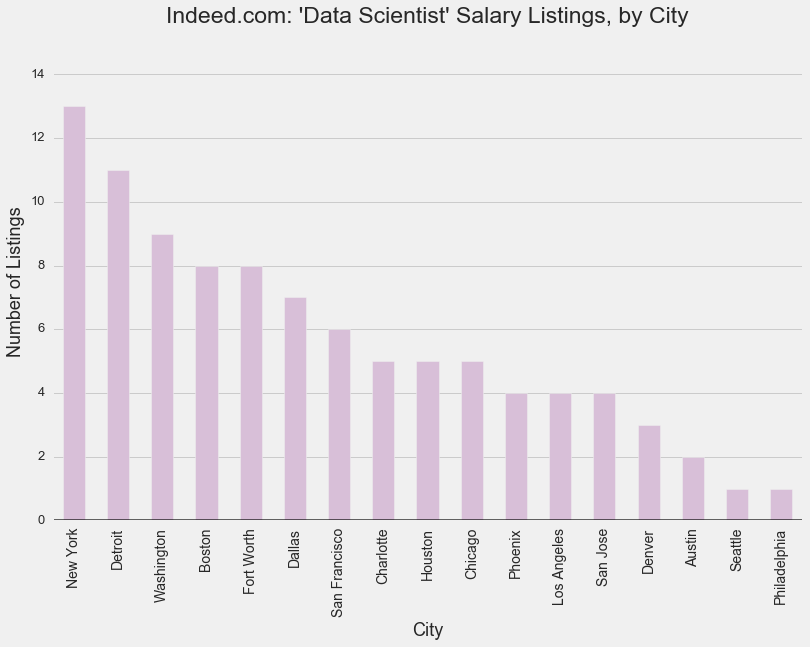

In [15]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df['city'].value_counts().plot.bar(color = 'thistle', alpha = 1.0)

plt.axhline(0, color='black', alpha = 0.6)

plt.title('Indeed.com: \'Data Scientist\' Salary Listings, by City', fontsize = 23, y = 1.03)

# y label
plt.ylabel('Number of Listings', fontsize = 18)
plt.ylim([0, 15])
plt.yticks(fontsize = 13)

# x label
plt.xlabel('City', fontsize = 18)
plt.xticks(fontsize = 14)

plt.grid(which = 'major', axis = 'x')

plt.show()

In [16]:
print 'The minimum salary listed is %s' %min(df['salary'])
df[df['salary'] == min(df['salary'])][['title', 'location', 'company', 'salary']]

The minimum salary listed is 45000.0


,title,location,company,salary
5,Machine Learning Scientist,"Boston, MA",Bison,45000.0
109,Data Science Pharma Manager,"New York, NY 10018 (Clinton area)",American Federation for Aging Research,45000.0


In [17]:
print 'The maximum salary listed is %s' %max(df['salary'])
df[df['salary'] == max(df['salary'])][['title', 'location', 'company', 'salary']]

The maximum salary listed is 200000.0


,title,location,company,salary
65,Machine Learning Scientist,"San Jose, CA 95113 (Downtown area)",Jobspring Partners,200000.0


In [18]:
df = df.reset_index(drop = True)

#### Compute the median salary and create a new binary target variable with 1 if the salary is above the median, and 0 otherwise:

In [19]:
df['target'] = [1 if x > df['salary'].median() else 0 for x in df['salary']]

Let's see it if looks like a 50-50 split of observations:

In [20]:
df['target'].value_counts()

1    48
0    48
Name: target, dtype: int64

Make a list of (non-unique) terms found in 'title' entries; ignore case and symbols:

In [21]:
df['title1'] = df['title'].apply(lambda x: list(set(re.sub(r'[^\w]', ' ', x.lower()).split(' '))))
df['title2'] = [None]*len(df)

stemmer = PorterStemmer()

for i in range(len(df)):
    df['title2'][i] = [x for x in df['title1'][i] if len(x) > 0]
    df['title2'][i] = [x.strip() for x in df['title2'][i]]
    df['title2'][i] = [x.replace('ai', 'artificial') for x in df['title2'][i]]
    df['title2'][i] = [x.replace('sr', 'senior') for x in df['title2'][i]]
    df['title2'][i] = [x.replace('jr', 'junior') for x in df['title2'][i]]
    df['title2'][i] = [stemmer.stem(x) for x in df['title2'][i]]

In [22]:
all_terms = []
for i in df['title2']:
    i = list(set(i))
    all_terms = all_terms + i
unique_terms = list(set(all_terms))
term_counts = []
for i in unique_terms:
    count = all_terms.count(i)
    term_counts.append(count)
count_df = pd.DataFrame([unique_terms, term_counts]).T
count_df.columns = ['term', 'count']
count_df = count_df[count_df['count'] > 1]
count_df = count_df.sort_values(by = 'count', ascending = False)
count_df

,term,count
11,scientist,71
49,data,63
61,learn,14
63,senior,12
35,machin,12
26,quantit,12
46,engin,11
21,analyst,11
14,research,9
1,nlp,7


In [23]:
terms = count_df[count_df['count'] > 1]['term']            

In [24]:
def dummies(feature, terms):
    lil_df = pd.DataFrame(columns = terms)
    for term in terms:
        lil_df[term] = [1 if term in x else 0 for x in feature]
    return lil_df

In [25]:
dummy_df = dummies(df['title2'], terms)

big_df = pd.concat([df.drop(['title1', 'title2'], axis = 1), dummy_df], axis = 1)

In [26]:
big_df = pd.concat([big_df.drop(['city', 'state'], axis = 1), 
                    pd.get_dummies(big_df[['city', 'state']], 
                    drop_first = True)], axis = 1)

Perform a logistic regression on the salary dummy column using the term dummy columns as model features:

In [27]:
big_df.columns

Index([             u'title',           u'location',            u'company',
                   u'salary',             u'target',          u'scientist',
                     u'data',              u'learn',             u'senior',
                   u'machin',            u'quantit',              u'engin',
                  u'analyst',           u'research',                u'nlp',
                    u'appli',           u'artifici',                u'big',
                   u'invest',            u'develop',             u'associ',
                   u'mutual',             u'scienc',           u'intellig',
                  u'liberti',             u'pharma',              u'manag',
                    u'chief',                u'and',           u'programm',
                       u'on',             u'analyt',                 u'di',
                    u'alexa',              u'model',                u'aut',
                    u'relev',            u'princip',            u'softwar',
            

In [28]:
X = big_df.drop(['title', 'location', 'company', 'salary', 'target'], axis = 1)

y = big_df['target']

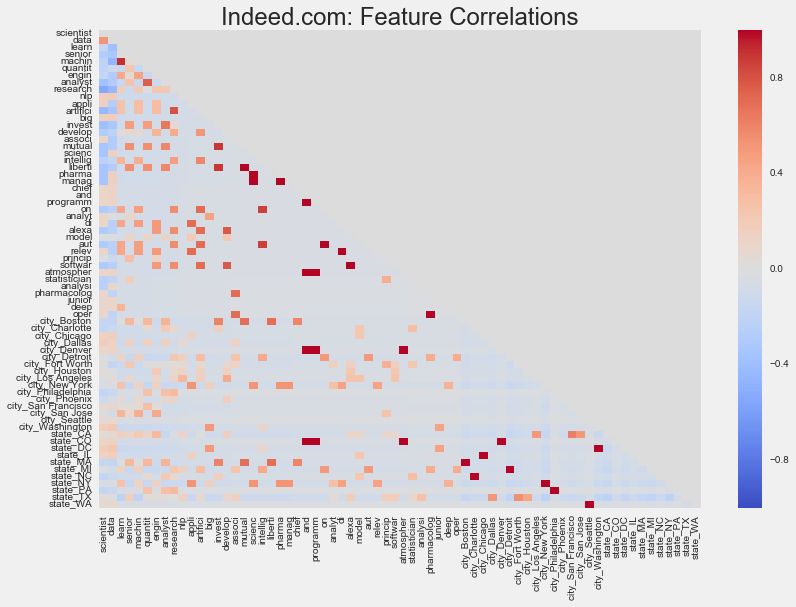

In [29]:
plt.figure(figsize = (12, 8))
plt.style.use('fivethirtyeight')

corr_mat = np.tril(X.corr(), k=-1)
sns.heatmap(corr_mat, cmap = 'coolwarm', alpha = 1)
plt.title('Indeed.com: Feature Correlations', fontsize = 24)
plt.xticks(np.arange(0.5, 68.5, 1), X.columns, fontsize = 10, rotation = 90)
plt.yticks(np.arange(0.5, 68.5, 1), list(X.columns)[::-1], fontsize = 10, rotation = 0)
plt.show()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [31]:
parameters = {
    'penalty' : ['l1', 'l2'],
    'C' : [0.01, 0.1, 0.5, 1.0, 5, 10, 100],
}

lr = LogisticRegression(fit_intercept = True, random_state=42, n_jobs = -1)

clf = GridSearchCV(lr, parameters, cv = 5)

clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 0.5, 1.0, 5, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [32]:
clf.best_params_

{'C': 5, 'penalty': 'l2'}

In [33]:
lr2 = LogisticRegression(fit_intercept = True, C = 5, penalty = 'l2')

lr2.fit(X_train, y_train)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
predictions = lr2.predict(X_test)
cm = confusion_matrix(predictions, y_test)
cm

array([[11,  4],
       [ 4, 10]])

In [35]:
accuracy_score(predictions, y_test)

0.72413793103448276

In [36]:
coefs = pd.DataFrame(index = X.columns)
coefs['coef'] = list(lr2.coef_)[0]
coefs['color'] = ['steelblue' if x <=0 else 'salmon' for x in coefs['coef']]
coefs['coef'] = [abs(x) for x in coefs['coef']]
coefs = coefs.sort_values(by = 'coef', ascending = False)

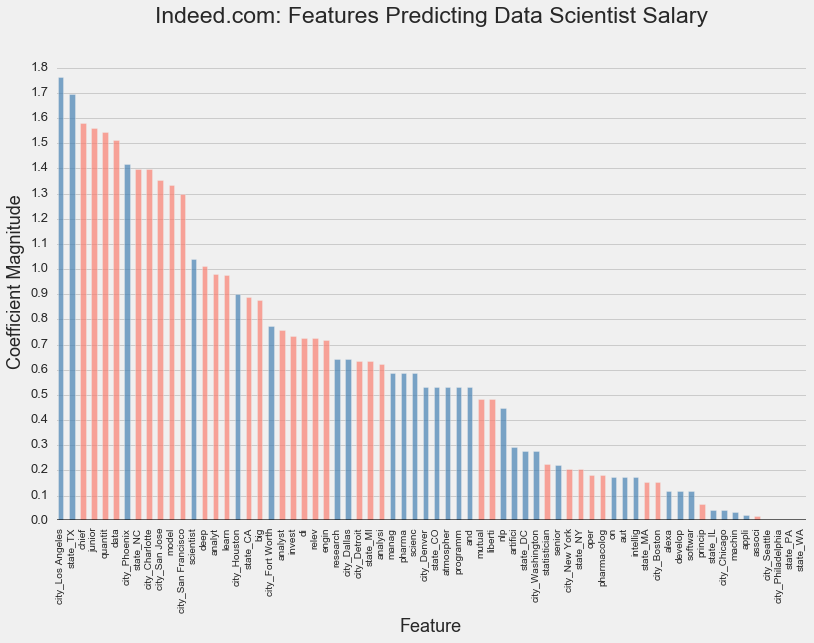

In [37]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

coefs['coef'].plot.bar(color = coefs['color'], alpha = 0.7)

plt.axhline(0, color='black', alpha = 0.6)

plt.title('Indeed.com: Features Predicting Data Scientist Salary', fontsize = 23, y = 1.03)

plt.ylabel('Coefficient Magnitude', fontsize = 18)
plt.ylim([0, 1.9])
plt.yticks(np.arange(0, 1.9, 0.1), fontsize = 13)

plt.xlabel('Feature', fontsize = 18)
plt.xticks(fontsize = 10)

plt.grid(which = 'major', axis = 'x')

plt.show()

In [38]:
accuracies = []
precisions = []
recalls = []

for i in range(1, len(X.columns)):
    pick_em = SelectKBest(f_classif, k=i)
    pick_em.fit(X_train, y_train)
    support = X.columns[pick_em.get_support()]
    lr2.fit(X_train[support], y_train)
    y_pred = lr2.predict(X_test[support])
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    
results = pd.DataFrame(index = range(len(X.columns) - 1))
results['accuracy'] = accuracies
results['precision'] = precisions
results['recall'] = recalls

In [39]:
results.head()

,accuracy,precision,recall
0,0.655172,0.583333,1.0
1,0.655172,0.583333,1.0
2,0.655172,0.583333,1.0
3,0.655172,0.583333,1.0
4,0.655172,0.583333,1.0


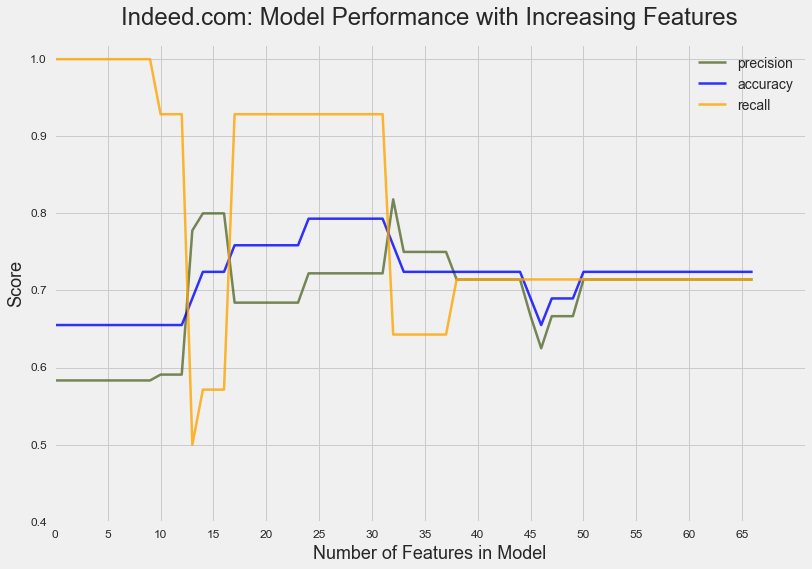

In [40]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

for i in [('precision', 'DarkOliveGreen'), ('accuracy', 'blue'), ('recall', 'Orange')]:
    plt.plot(results.index, results[i[0]], color = i[1], linewidth = 2.5, \
         label = i[0], alpha = 0.8)

plt.axhline(0, color='black', alpha = 0.6)
plt.title('Indeed.com: Model Performance with Increasing Features', fontsize = 24, y = 1.03)

# y label
plt.ylabel('Score', fontsize = 18)
plt.yticks(np.arange(0, 1.2, 0.1), fontsize = 12)

# x label
plt.xlabel('Number of Features in Model', y = 0.1, fontsize = 18)
plt.xticks(range(0, 70, 5), fontsize = 12)

plt.xlim([-0.1, 71])
plt.ylim([0.4, 1.02])
plt.legend(loc='best', fontsize = 14)

plt.show()

In [41]:
pick_em = SelectKBest(f_classif, k=24)
pick_em.fit(X_train, y_train)
support = X.columns[pick_em.get_support()]
support

Index([             u'learn',            u'quantit',                u'nlp',
                   u'invest',             u'mutual',            u'liberti',
                      u'and',           u'programm',          u'atmospher',
              u'city_Boston',     u'city_Charlotte',        u'city_Dallas',
              u'city_Denver',    u'city_Fort Worth',       u'city_Houston',
         u'city_Los Angeles',       u'city_Phoenix', u'city_San Francisco',
            u'city_San Jose',           u'state_CA',           u'state_CO',
                 u'state_MA',           u'state_NC',           u'state_TX'],
      dtype='object')

In [43]:
lr2.fit(X_train[support], y_train)
predictions = lr2.predict(X_test[support])
cm = confusion_matrix(predictions, y_test)
cm

array([[ 9,  1],
       [ 6, 13]])

In [44]:
def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Positive','Negative'], \
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels, fontsize = 14)
    plt.yticks(tick_marks, labels, rotation = 90, fontsize = 14)
        
    plt.title(title, fontsize = 24)
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=40).set_path_effects([path_effects.Stroke(linewidth=1, \
                            foreground='black'), path_effects.Normal()])
    return

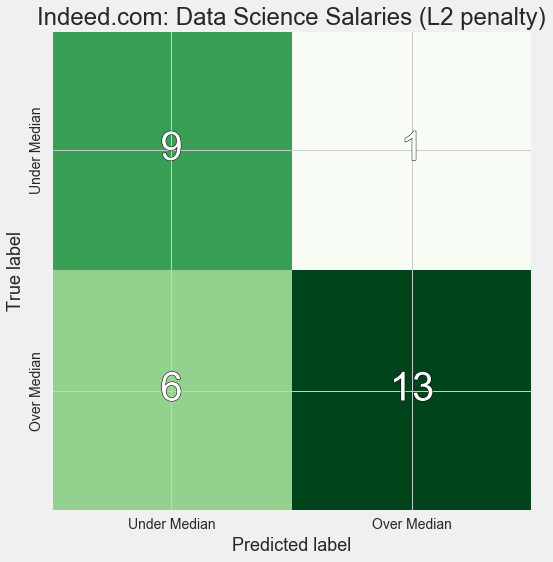

In [45]:
plot_confusion_matrix(cm, title='Indeed.com: Data Science Salaries (L2 penalty)', \
                      labels=['Under Median', 'Over Median'], cmap=plt.cm.Greens)

In [46]:
roc = roc_curve(y_test, predictions)
roc

(array([ 0. ,  0.4,  1. ]),
 array([ 0.        ,  0.92857143,  1.        ]),
 array([2, 1, 0]))

In [50]:
pred1 = lr2.predict_proba(X_train[support]).T[1]
roc = roc_curve(y_train, pred1)

In [51]:
def getROCcurve(roc, title='ROC Curve', xlabel ='% of False Positives', \
                ylabel = '% of True Positives'):
    fpr, tpr, thresholds = roc
    plt.figure(figsize = (12,8))
    plt.style.use('fivethirtyeight')
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(7, 6, forward=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    #plt.legend(loc='best')
    plt.plot([0, 1], [0, 1], 'k--', linewidth = 0.4, color = 'magenta')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    return plt.show()

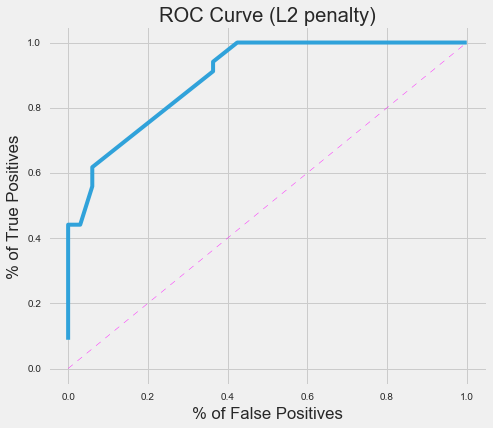

In [52]:
getROCcurve(roc, title='ROC Curve (L2 penalty)', xlabel ='% of False Positives', \
            ylabel = '% of True Positives')

This model gives us slightly better-than-random predictions about whether a given salary from our list of cities on Indeed.com will fall above or below the threshhold (median) salary.  The model's accuracy -- the rate at which it identies positives and negatives correctly -- is 0.60, or 10% better than random guessing.  Its precision -- the proportion of positives it classifies that are true positives -- is slightly higher, meaning that more of its mistakes must be made in misidentifying the negatives.  Its recall -- the probability that a true positive will be correctly classified -- is pretty low. 

We would want a high-recall model if we needed to be sure of correctly classifying all above-median salaries as such (e.g., misclassifying more geese as planes in order to correctly identify as many planes as possible).  If we didn't need to relocate for a move, for example, we might want to find any jobs that are likely to be over the salary threshhold while at the same time be willing to misclassify some that are below it.  A high-precision model would be useful in this salary scenario if, for example, we were considering relocating for a job and in order to focus our attention needed to be pretty sure that the salary would be over the threshhold.